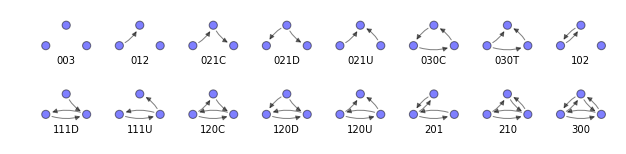

In [1]:
## following the example in Chapter 5 of SNAFS
import hide_code.hide_code as hc
import sys
import os
import csv 
import math
from __future__ import division
import numpy as np
import scipy
import networkx as net
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (21, 14)
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.tools as tls
tls.set_credentials_file(username='tdetz', api_key='705bdng1xl')
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
import plotly.graph_objs as go
import cufflinks as cf
from networkx import algorithms
from operator import itemgetter
import pandas as pd
import triadic
import draw_triads

In [2]:
## SNAFS: Import bi-partite (bi-modal) functions
from networkx.algorithms import bipartite as bi

def trim_edges(g, weight=1):
    g2=net.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [3]:
## SNAFS: get a sorted degree list to obtain topmost nodes
def sorted_map(map):
    ms = sorted(map.iteritems(), key=lambda k, v: (-v, k))
    return ms

In [4]:
## read in the pac expenditure data
spacs=pd.read_csv("spacs-csv.csv")


**Project 1**  
**IS 620**  
**Tom Detzel**  
*Oct. 3, 2016*  



## Introduction

*Note: To show/hide python code in this notebook, toggle the </> button in the toolbar.*

For this project, we are asked to identify, prepare and an analyze a network dataset with nodes that include at least one categorical attribute; to calculate centrality measures; and to compare the centrality measures for each category. I chose Federal Election Commission data for independent expenditure committees, also know as SuperPACs, for the 2016 presidential candidates. Committees and candidates are nodes in the data. Edges are contributions made in support of or in opposition to a particular candidate. An initial hypothesis was that the Hillary Clinton and Donald Trump campaigns would show significant differences in centrality measures. Trump, as a political outsider, has a smaller network of supporters and a larger network of opponents in his own party and among Democrats. Clinton, with decades in national politics, has a longstanding and loyal network of donors but also faced only a single strong opponent in the primary who did not have a significant SuperPac.

A network analysis suggest that, in fact, the candidates are comparable when evaluating overall spending. When subnetworks of support and opposition spending are teased out, differences appear. In the spending against category, Trump ranks at the top on measures of Betweenness, Eigenvector centrality and Closeness. This may be a reflection of the long primary campaign and SuperPacs attacks from Republicans. Clinton scores higher than Trump on more centrality measures in the support category; she had the plurality of donors in this category.

Measures of Betweenness, PageRank and Degree centrality were tested using the Kendall's Tau test for ranked data. Results showed a high (.86) positive correlation between Degree centrality and Betweenness, consistent with the dominant influence of the Clinton and Trump campaigns as frontrunners throughout the primary season. 

### 1. Data Preparation

Data were downloaded from the FEC's disclosure portal at http://www.fec.gov/portal/super_pacs.shtml2.1 on Sept. 28, 2016 and reflect SuperPAC spending for the presidential primaries and general election through that date. The data included 42,556 records describing contributions from 198 SuperPACs to 21 candidates. OpenRefine was used to clean the data and standardize spellings for SuperPAC and candidate names. To make graphs more readable and capture spending by only the most influential SuperPacs, those that spent less than the median combined amount were eliminated. That left 99 SuperPacs with 41,045 contributions, capturing nearly all of the money spent. **Table 1** below shows a sample of cleaned-up data, and the bar chart shows the distribution of spending by candidate.

Trump was the target of 47 percent of the $\$$600 million in total spending. The $\$$272 million spent on him overall was evenly split in support and opposition. By comparsion, $\$$2 of every $\$$3 spent on Clinton is opposition money, and SuperPacs have only spent $\$$71 million on her overall. The money aimed at Trump is heavily weighted toward a single SuperPAC, Bring Our Jobs Back, which reported spending $\$$100 million to back him. (The group is run by businessman Steven Hoffenberg, who was convicted and did federal time in the 1990s for running [a Ponzi scheme](http://politi.co/2dEwOuF). I looked at [Hoffenberg's filings](http://bit.ly/2dqgX3L), and it's unclear whether his SuperPac money was actually spent. He's [a bit of a whacko](http://bit.ly/2cO8dSs).)


In [5]:
## spacs.head(2)

In [6]:
## check to be sure we have the right pacs
pacs_agg = spacs.groupby(['pac_ID', 'pac'], as_index=False)['amount'].sum()

## top half by spending
tot_nodes = len(pacs_agg.sort_values(['amount'], ascending=False)[:])

## get pacs that spent more than the median amount
trim_pacs = pacs_agg[pacs_agg.amount > pacs_agg.amount.median()]

## check to be sure it's approximately half of PACs
top_spenders = list(trim_pacs['pac_ID'].unique())
trim_nodes = len(top_spenders)

## limit data to those top-spending PACs
new_pacs = spacs[spacs['pac_ID'].isin(top_spenders)]

## this list still incorporates most of the data, so it's OK to eliminate low-spending PACs
contrib = len(new_pacs)

#### Table 1: Raw FEC data

In [7]:
## take a peek at the data now
new_pacs.head(2)

,cand_ID,candidate,pac_ID,pac,election,office_state,district,office,party,amount,exp_dat,sup_opp,paid_To
0,P80001571,Trump Donald,C00489799,Planned Parenthood,P,CA,0,P,NaN,5003,5/28/16,Oppose,null
1,P00003392,Clinton Hillary,C00489799,Planned Parenthood,G,US,0,P,Dem,2050,7/27/16,Support,76 Words


In [8]:
## prep data for bar chart in plotly
dist = new_pacs.groupby(['candidate', 'sup_opp'], as_index=False)['amount'].sum()
dist = dist.sort_values(['amount'], ascending=False)

In [9]:
total = new_pacs['amount'].sum()

In [10]:
dist['percent'] = dist.amount/total

#### Table 2: Aggregate spending, top targets

In [11]:
dist['amount'] = dist['amount'].map('${:,.0f}'.format)
dist['percent'] = dist['percent'].map('{:.2f}'.format)
dist.columns = ['Candidate', 'Position', 'Amount', 'Percent']
dist[0:9]

,Candidate,Position,Amount,Percent
33,Trump Donald,Oppose,"$139,034,892",0.23
34,Trump Donald,Support,"$133,139,397",0.22
1,Bush Jeb,Support,"$83,957,124",0.14
6,Clinton Hillary,Oppose,"$44,930,119",0.07
28,Rubio Marco,Support,"$41,234,352",0.07
7,Clinton Hillary,Support,"$26,386,251",0.04
9,Cruz Ted,Support,"$22,945,986",0.04
5,Christie Christoper J,Support,"$19,033,704",0.03
20,Kasich John,Support,"$16,707,339",0.03


In [12]:
# new_pacs['amount'].sum()
# new_pacs.groupby(['sup_opp'], as_index=False)['amount'].sum()

#### Figure 1: Nearly half the reported SuperPAC spending was aimed at Trump.

In [13]:
## bar chart of spending for-against candidates

data = [
    go.Bar(
        x=dist['Candidate'], # assign x as the dataframe column 'x'
        y=dist['Amount']
    )
]

layout = dict(
        title = 'Overall Spending For-Against by Candidate',
        showlegend = False)
# IPython notebook
# py.iplot(data, filename='pandas-bar-chart')

#url = py.plot(data, filename='pandas-bar-chart')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='angled-text-bar')

In [14]:
## print ("Total number of PACS in data: ", tot_nodes)
## print ("PACS, spending > median: ", trim_nodes)
## print ("Count of Contributions: ", contrib)

In [15]:
## get the total spent by each pac for each candidate, and whether it was in support or opposition
new_pacs_agg = new_pacs.groupby(['pac_ID', 'pac', 'candidate', 'sup_opp'], as_index=False)['amount'].sum()

#### Table 3: Top SuperPACS by Amount

In [16]:
top_spend = new_pacs_agg.sort_values(['amount'], ascending=False)[0:9]
top_spend['amount'] = new_pacs_agg['amount'].map('${:,.0f}'.format)
top_spend.columns = ['Pac_ID', 'SuperPAC', 'Candidate', 'Position', 'Amount']
top_spend

,Pac_ID,SuperPAC,Candidate,Position,Amount
177,C00616078,Get Our Jobs Back,Trump Donald,Support,"$100,020,332"
109,C00571372,Right To Rise USA,Bush Jeb,Support,"$83,948,711"
64,C00495861,Priorities USA Action,Trump Donald,Oppose,"$67,057,906"
89,C00541292,Conservative Solutions PAC,Rubio Marco,Support,"$40,303,724"
168,C00608489,Great America PAC,Trump Donald,Support,"$23,830,919"
165,C00603621,Our Principles PAC,Trump Donald,Oppose,"$19,039,615"
117,C00573055,America Leads,Christie Christoper J,Support,"$19,025,132"
179,C00618876,Rebuilding America Now,Clinton Hillary,Oppose,"$14,465,417"
140,C00581868,New Day for America,Kasich John,Support,"$11,225,615"


In [17]:
## column names for plotting
new_pacs_agg.columns=['Pac_ID','PAC','Candidate','Position','weight']

### 2. Exploratory Plots
Plots in this section provide an overall look at the network of SuperPACs and Candidates. **Figure 2** is an overall look at a directed graph based on total spending. **Figures 3 and 4** are subgraphs based on spending in support and in opposition, respectively. The direction of spending (from PAC to Candidate) is indicated by the fat end of each edge; the weight (amount) is indicated by the length of this fat edge. Red and blue lines indicate total spending of more or less than $1 million. There are 120 nodes in the network and 216 edges. The average degree centrality is 1.8; Trump and Clinton each have an overall degree centrality of 48. Degree centrality is defined as the number of links for a specific node. Looking at subgraphs exposes differences between the two candidates. Trump is the target of more opponents (34 degrees versus 22 for Clinton), and Clinton has greater degree centrality from SuperPacs that gave in support (26 versus 14 for Trump).   

In [18]:
## add edges and attributes (amount spent and whether oppose or support)
G = net.from_pandas_dataframe(new_pacs_agg, 'PAC', 'Candidate', ['Position', 'weight'], create_using=net.DiGraph())

In [19]:
## some statistics
## order() returns the number of nodes; size() returns the number of edges
## degree is a measure of the size of a node's network -- how many contributions sent or received?

## some statistics on subgraphs -- Support
n, k = G.order(), G.size()
avg_deg = float(k) / n

hrc = net.degree(G,['Clinton Hillary'])
trump = net.degree(G,['Trump Donald'])

print ""
print "Network Summary -- Overall Spending"
print "-----------------------------------"
print "Nodes: ", n
print "Edges: ", k
print "Average degree: ", round(avg_deg,3)
print "Strongly Connected Components: ", net.number_strongly_connected_components(G)
print "Weakly Connected Components: ", net.number_weakly_connected_components(G)
print ""
print "Degree Centrality"
print "-----------------"
print "Clinton: ", hrc
print "Trump: ", trump


Network Summary -- Overall Spending
-----------------------------------
Nodes:  120
Edges:  216
Average degree:  1.8
Strongly Connected Components:  120
Weakly Connected Components:  1

Degree Centrality
-----------------
Clinton:  {'Clinton Hillary': 48}
Trump:  {'Trump Donald': 48}


#### Figure 2. The network overall

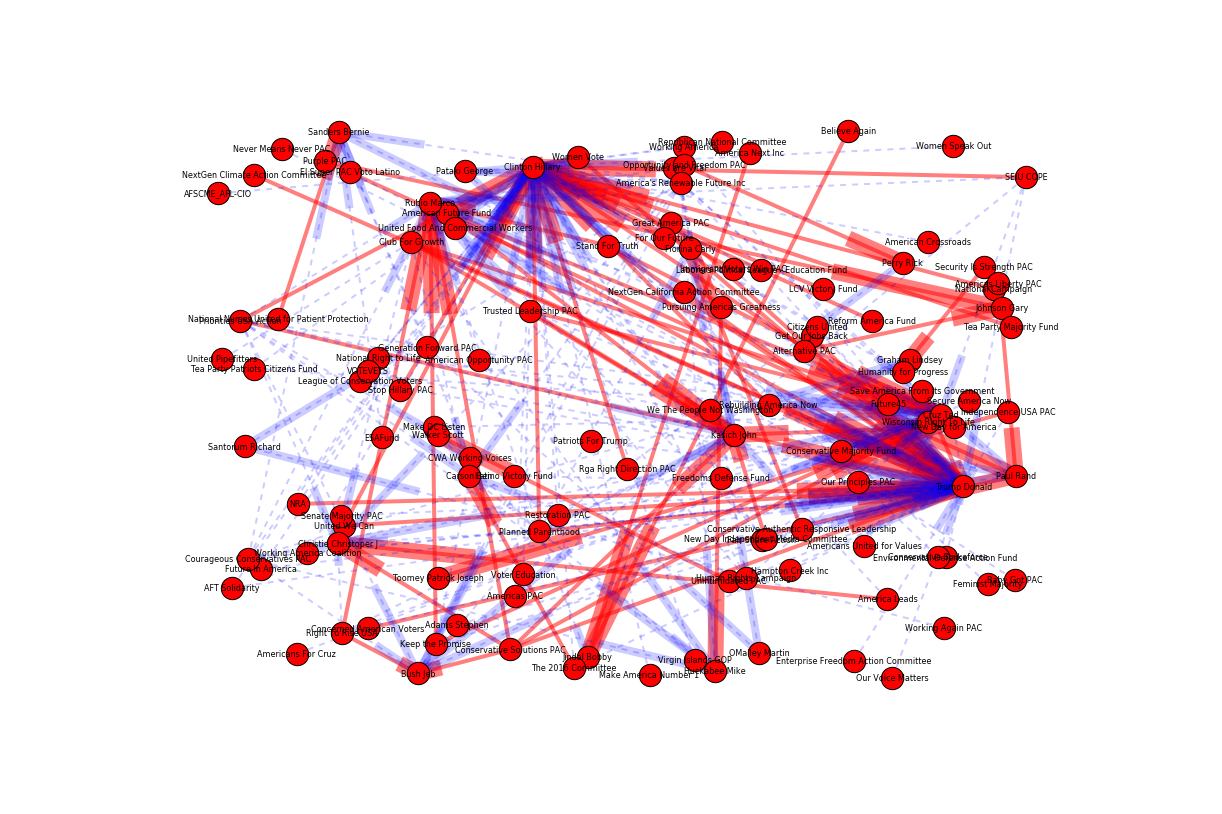

In [39]:
## plot the overall network of contributions
pos=net.random_layout(G) # positions for all nodes

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1000000]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1000000]

# nodes
net.draw_networkx_nodes(G,pos,node_size=500)
# edges
net.draw_networkx_edges(G,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(G,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [20]:
## make a subgraph with just the 'support' attribute
G2 = net.DiGraph(((source, target, attr) for source, target, attr in G.edges_iter(data=True) if attr['Position']=='Support'))

In [21]:
## some statistics on subgraphs -- Support
n, k = G2.order(), G2.size()
avg_deg = float(k) / n

hrc = net.degree(G2,['Clinton Hillary'])
trump = net.degree(G2,['Trump Donald'])

print ""
print "Network Summary -- Spending in Support"
print "--------------------------------------"
print "Nodes: ", n
print "Edges: ", k
print "Average degree: ", round(avg_deg,3)
print "Strongly Connected Components: ", net.number_strongly_connected_components(G2)
print "Weakly Connected Components: ", net.number_weakly_connected_components(G2)
print ""
print "Degree Centrality"
print "-----------------"
print "Clinton: ", hrc
print "Trump: ", trump


Network Summary -- Spending in Support
--------------------------------------
Nodes:  93
Edges:  91
Average degree:  0.978
Strongly Connected Components:  93
Weakly Connected Components:  7

Degree Centrality
-----------------
Clinton:  {'Clinton Hillary': 26}
Trump:  {'Trump Donald': 14}


#### Figure 3: Spending in support of the candidates

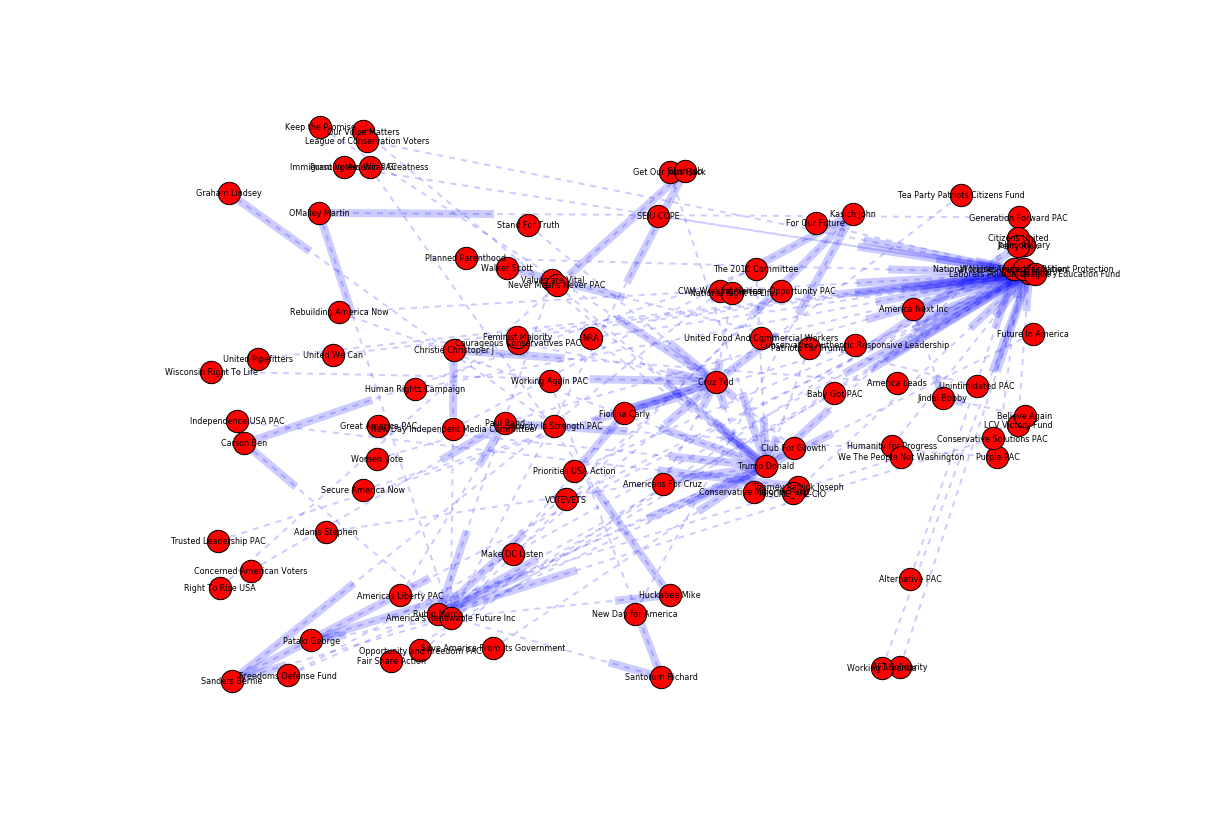

In [42]:
## plot the network of contributions in SUPPORT
pos=net.random_layout(G2) # positions for all nodes

#elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >500000]
#esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=500000]

# nodes
net.draw_networkx_nodes(G2,pos,node_size=500)
# edges
#net.draw_networkx_edges(G2,pos, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(G2,pos, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(G2,pos,font_size=8,font_family='sans-serif')

# plt.title('\n PAC Spending in Support of Presidential Candidates', fontsize=24, loc='left')
plt.axis('off')
plt.show()

In [22]:
## make a subgraph with just the 'oppose' attribute
G3 = net.DiGraph(((source, target, attr) for source, target, attr in G.edges_iter(data=True) if attr['Position']=='Oppose'))

In [23]:
## some statistics on subgraphs -- Opposition
n, k = G3.order(), G3.size()
avg_deg = float(k) / n

hrc = net.degree(G3,['Clinton Hillary'])
trump = net.degree(G3,['Trump Donald'])

print ""
print "Network Summary -- Spending in Opposition"
print "--------------------------------------"
print "Nodes: ", n
print "Edges: ", k
print "Average degree: ", round(avg_deg,3)
print "Strongly Connected Components: ", net.number_strongly_connected_components(G3)
print "Weakly Connected Components: ", net.number_weakly_connected_components(G3)
print ""
print "Degree Centrality"
print "-----------------"
print "Clinton: ", hrc
print "Trump: ", trump


Network Summary -- Spending in Opposition
--------------------------------------
Nodes:  77
Edges:  125
Average degree:  1.623
Strongly Connected Components:  77
Weakly Connected Components:  1

Degree Centrality
-----------------
Clinton:  {'Clinton Hillary': 22}
Trump:  {'Trump Donald': 34}


#### Figure 4: Spending in opposition to the candidates

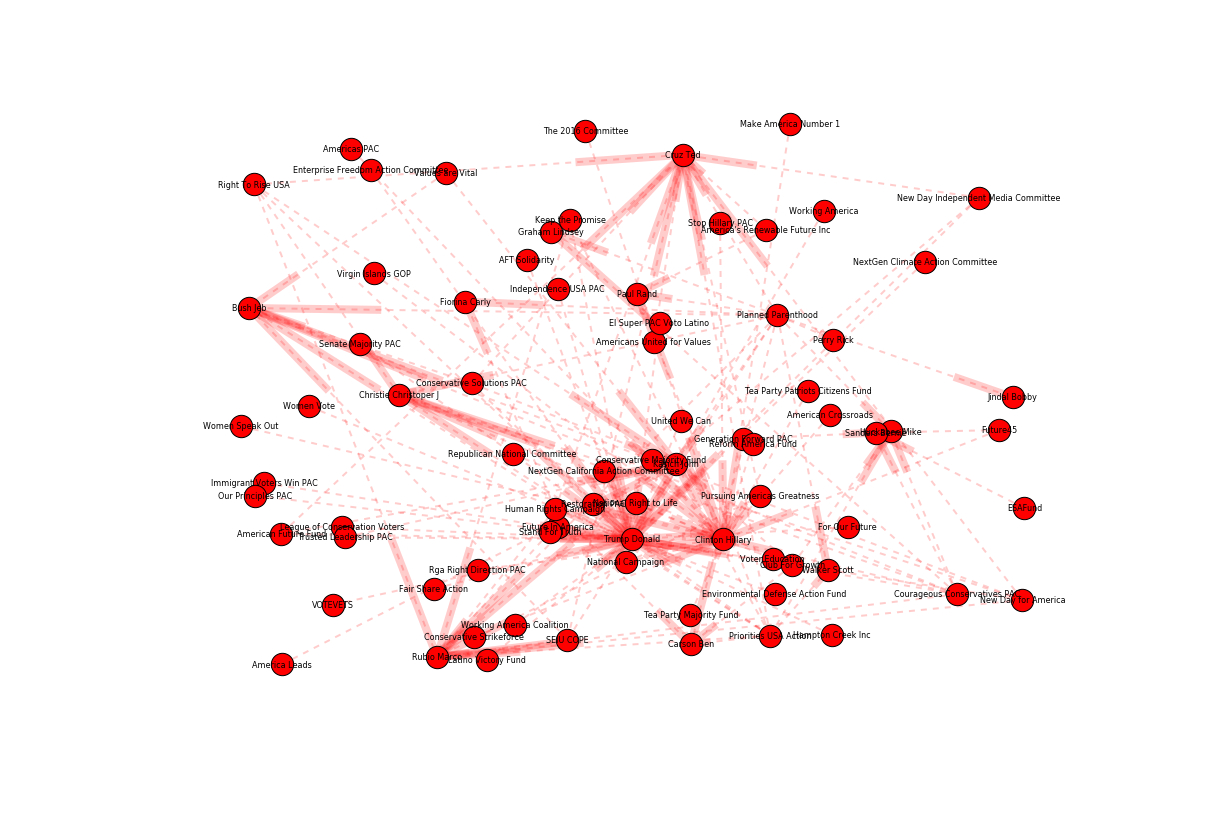

In [45]:
## plot the network of contributions OPPOSED
pos=net.random_layout(G3) # positions for all nodes

#elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >500000]
#esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=500000]

# nodes
net.draw_networkx_nodes(G3,pos,node_size=500)
# edges
#net.draw_networkx_edges(G3,pos, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(G3,pos, width=2,alpha=0.2,edge_color='r',style='dashed')

# labels
net.draw_networkx_labels(G3,pos,font_size=8,font_family='sans-serif')

# plt.title('\n PAC Spending in Opposition to Presidential Candidates', fontsize=24, loc='left')
plt.axis('off')
plt.show()

In [24]:
## to get centrality and clustering measures, must convert to undirected graph
G_ud = G.to_undirected()
G2_ud = G2.to_undirected()
G3_ud = G3.to_undirected()

In [25]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

### 3. Betweenness, Closeness, Eigenvector Centrality

To compute these measures of centrality, we first convert to undirected graph databases for each category of spending -- overall, support and opposed. In overall spending, the two candidates have virtually identical measures. The differences appear in the support or oppose networks.  Trump scores at the top in every measure in the opposition spending network, a reflection of the large number of SuperPacs that targeted him for defeat. Clinton's Betweenness score is double that of Trump's among supporitive SuperPacs. Betweenness measure the number of times a node is the shortest path between other nodes; Closeness is the average length of the shortest path between a node and other connected nodes. As noted above, Clinton, with more supporting PACs than Trump, has higher Degree centrality and marginally higher Closeness. Trump scores higher Eigenvector scores in both spending catgories; this measure puts a premium on being connected to other influential (highly connected) nodes.

In [26]:
# Connected components are sorted in descending order of their size
G_components = list(net.connected_component_subgraphs(G_ud))
G_mc = G_components[0]

# Betweenness centrality
bet_cen = net.betweenness_centrality(G_ud)

# Closeness centrality
clo_cen = net.closeness_centrality(G_ud)

# Eigenvector centrality
eig_cen = net.eigenvector_centrality_numpy(G_ud)

# Degree centrality
deg_cen = net.degree_centrality(G_ud)

In [27]:
## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

#### Table 4: Centrality measures, overall spending

In [28]:
## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

In [29]:
cent_measures=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])

In [30]:
cent_measures[['Betweenness', 'Closeness', 'Eigenvector', 'Degree']] = cent_measures[['Betweenness', 'Closeness', 'Eigenvector', 'Degree']].astype('float64')
cent_measures.head()

,Node,Betweenness,Node,Closeness,Node,Eigenvector,Node,Degree
0,Clinton Hillary,0.422756,America's Renewable Future Inc,0.493776,Trump Donald,0.706759,Clinton Hillary,0.403361
1,Trump Donald,0.399852,Planned Parenthood,0.489712,Get Our Jobs Back,0.562672,Trump Donald,0.403361
2,America's Renewable Future Inc,0.186061,Trump Donald,0.485714,Priorities USA Action,0.378127,Cruz Ted,0.201681
3,Planned Parenthood,0.178467,Clinton Hillary,0.481781,Great America PAC,0.134063,Rubio Marco,0.142857
4,Cruz Ted,0.130185,Priorities USA Action,0.455939,Our Principles PAC,0.107109,America's Renewable Future Inc,0.126050


In [31]:
# Connected components are sorted in descending order of their size
G_components = list(net.connected_component_subgraphs(G2_ud))
G_mc = G_components[0]

# Betweenness centrality
bet_cen = net.betweenness_centrality(G2_ud)

# Closeness centrality
clo_cen = net.closeness_centrality(G2_ud)

# Eigenvector centrality
eig_cen = net.eigenvector_centrality_numpy(G2_ud)

# Degree centrality
deg_cen = net.degree_centrality(G2_ud)

In [32]:
## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

#### Table 5: Centrality measures, spending in support

In [33]:
## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

In [34]:
cent_measures2=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])

In [35]:
cent_measures2[['Betweenness', 'Closeness', 'Eigenvector', 'Degree']] = cent_measures2[['Betweenness', 'Closeness', 'Eigenvector', 'Degree']].astype('float64')
cent_measures2

,Node,Betweenness,Node,Closeness,Node,Eigenvector,Node,Degree
0,America's Renewable Future Inc,0.482346,America's Renewable Future Inc,0.382133,Trump Donald,0.707107,Clinton Hillary,0.282609
1,Clinton Hillary,0.340739,Clinton Hillary,0.332290,Get Our Jobs Back,0.687009,Trump Donald,0.152174
2,Rubio Marco,0.249403,Rubio Marco,0.305707,Great America PAC,0.163687,America's Renewable Future Inc,0.141304
3,Cruz Ted,0.181319,Trump Donald,0.293949,Rebuilding America Now,0.031808,Cruz Ted,0.130435
4,Club For Growth,0.180602,Kasich John,0.265832,NRA,0.011236,Rubio Marco,0.065217
5,Trump Donald,0.164716,Sanders Bernie,0.265832,Save America From Its Government,0.006971,Paul Rand,0.032609
6,Kasich John,0.035117,Pataki George,0.263540,Adams Stephen,0.004498,Kasich John,0.032609
7,Sanders Bernie,0.035117,Bush Jeb,0.263540,Patriots For Trump,0.002913,Sanders Bernie,0.032609
8,Pataki George,0.017678,Carson Ben,0.263540,The 2016 Committee,0.002136,Purple PAC,0.021739
9,Bush Jeb,0.017678,Huckabee Mike,0.263540,Citizens United,0.001491,Jindal Bobby,0.021739


In [182]:
# Connected components are sorted in descending order of their size
G_components = list(net.connected_component_subgraphs(G3_ud))
G_mc = G_components[0]

# Betweenness centrality
bet_cen = net.betweenness_centrality(G3_ud)

# Closeness centrality
clo_cen = net.closeness_centrality(G3_ud)

# Eigenvector centrality
eig_cen = net.eigenvector_centrality_numpy(G3_ud)

# Degree centrality
deg_cen = net.degree_centrality(G3_ud)

In [183]:
## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

#### Table 6: Centrality measures, spending in opposition

In [184]:
## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

In [185]:
cent_measures3=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])

In [186]:
cent_measures3[['Betweenness', 'Closeness', 'Eigenvector', 'Degree']] = cent_measures3[['Betweenness', 'Closeness', 'Eigenvector', 'Degree']].astype('float64')
cent_measures3

,Node,Betweenness,Node,Closeness,Node,Eigenvector,Node,Degree
0,Trump Donald,0.575733,Trump Donald,0.524138,Trump Donald,0.707069,Trump Donald,0.447368
1,Clinton Hillary,0.452514,Courageous Conservatives PAC,0.481013,Priorities USA Action,0.659342,Clinton Hillary,0.289474
2,Courageous Conservatives PAC,0.314116,Keep the Promise,0.436782,Our Principles PAC,0.187205,Planned Parenthood,0.184211
3,Keep the Promise,0.142537,Planned Parenthood,0.413043,Club For Growth,0.103812,Cruz Ted,0.157895
4,Planned Parenthood,0.140644,Clinton Hillary,0.397906,NextGen California Action Committee,0.071308,Rubio Marco,0.144737
5,Rubio Marco,0.083873,Rubio Marco,0.397906,American Future Fund,0.068016,Priorities USA Action,0.131579
6,Cruz Ted,0.064739,Priorities USA Action,0.395833,United We Can,0.064295,Kasich John,0.118421
7,Sanders Bernie,0.059192,Christie Christoper J,0.381910,Conservative Solutions PAC,0.047608,Courageous Conservatives PAC,0.105263
8,Priorities USA Action,0.058711,Bush Jeb,0.381910,NextGen Climate Action Committee,0.042058,Christie Christoper J,0.092105
9,Kasich John,0.042873,Right To Rise USA,0.376238,Women Vote,0.024610,Bush Jeb,0.092105


In [187]:
cc = max(net.connected_component_subgraphs(G_ud), key=len)

### 4. Ego Networks, Triads

A look at subgraphs centered on Clinton and Trump exposes the overlap in SuperPac activity in their individual networks. Clinton's network includes 1,847 structural holes -- situations in which PACs spent on her behalf and against Trump. Most of the biggest SuperPacs are on this list, including Priorities USA. The triads can be seen in the network plot in **Figure 5** below. Red edges indicate spending of more than $1 million; Trump's graph clearly shows the effect of big money on his campaign, as well as large amounts spent on his primary competitors.

In [188]:
## find an ego network for Hillary Clinton
hrc_graph = net.ego_graph(cc, 'Clinton Hillary', radius=2)

#### Figure 5: The Clinton ego network

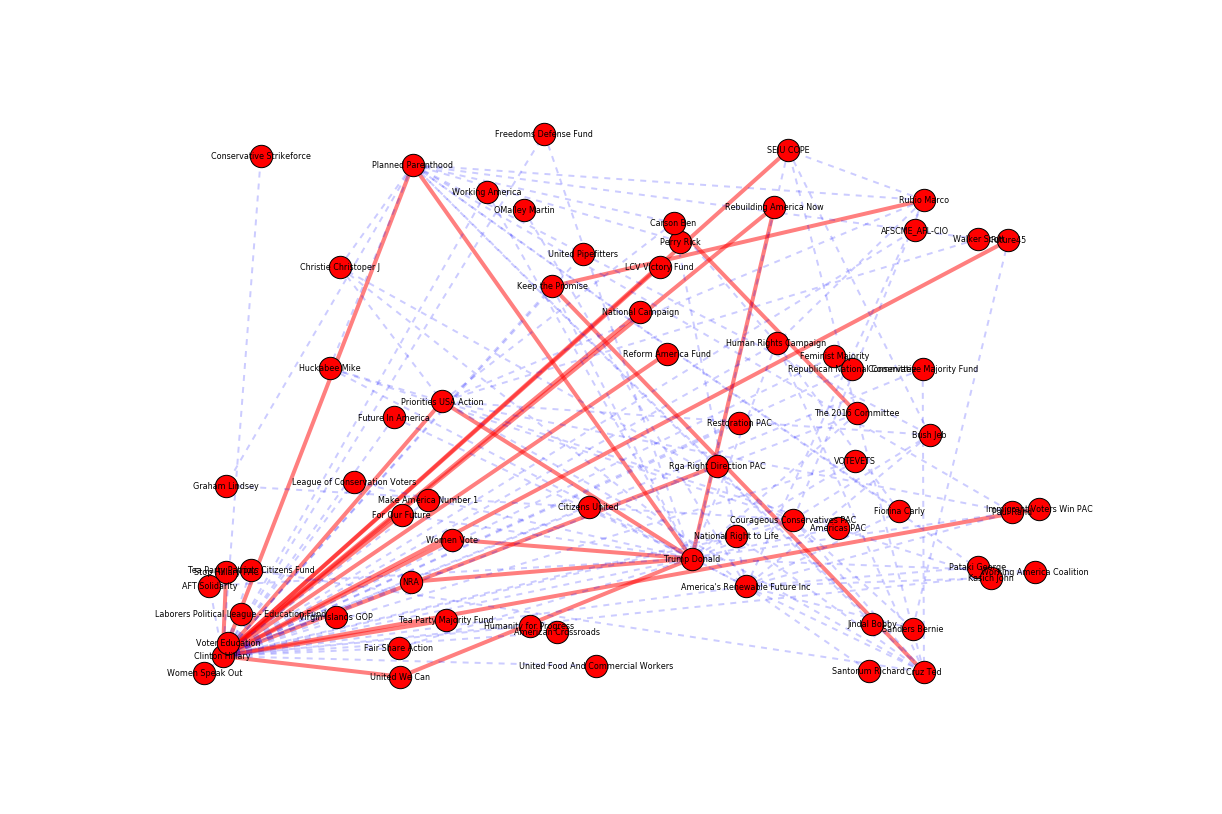

In [189]:
## plot it
pos=net.random_layout(hrc_graph) # positions for all nodes

# nodes
net.draw_networkx_nodes(hrc_graph,pos,node_size=500)

# edges
elarge=[(u,v) for (u,v,d) in hrc_graph.edges(data=True) if d['weight'] >1000000]
esmall=[(u,v) for (u,v,d) in hrc_graph.edges(data=True) if d['weight'] <=1000000]
net.draw_networkx_edges(hrc_graph,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(hrc_graph,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(hrc_graph,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [190]:
## look for triads in Hillary's ego network
## hrc_di=net.DiGraph(hrc_graph)
# census, node_census=triadic.triadic_census(hrc_graph)
# census

#### Table 7: SuperPac crossover in Clinton network

In [191]:
h2=trim_edges(hrc_graph, weight=0.5)
hcliques = pd.DataFrame(list(net.find_cliques(h2)))
hcliques.columns=['Candidate', 'SuperPac']
hcliques2 = hcliques.groupby(['Candidate'], as_index=False).count()
hcliques2.sort_values('SuperPac', ascending=False)[0:5]

,Candidate,SuperPac
3,Clinton Hillary,48
17,Trump Donald,23
4,Cruz Ted,10
14,Rubio Marco,7
0,Bush Jeb,5


In [192]:
## find an ego network for Donald Trump
trump_graph = net.ego_graph(cc, 'Trump Donald', radius=2)

#### Figure 6: The Trup ego network

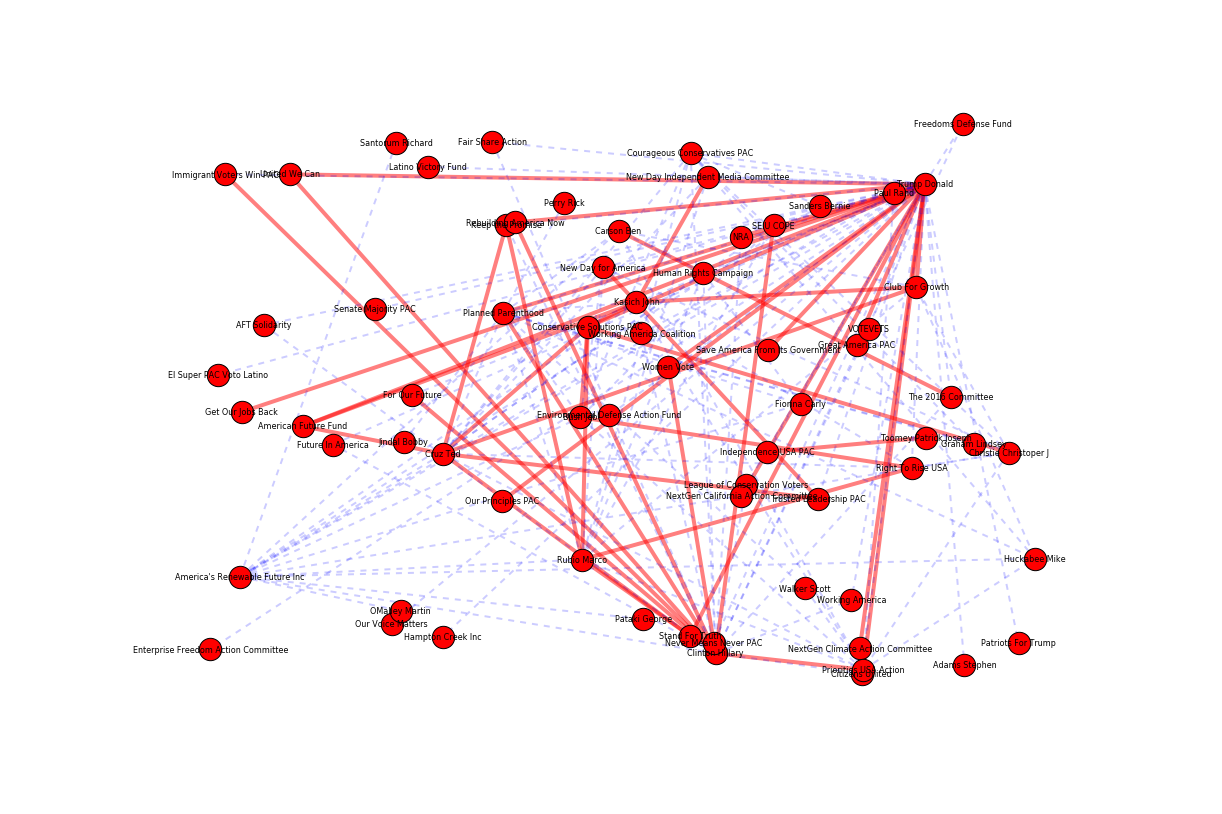

In [193]:
## plot it
pos=net.random_layout(trump_graph) # positions for all nodes

# nodes
net.draw_networkx_nodes(trump_graph,pos,node_size=500)

# edges
elarge=[(u,v) for (u,v,d) in trump_graph.edges(data=True) if d['weight'] >1000000]
esmall=[(u,v) for (u,v,d) in trump_graph.edges(data=True) if d['weight'] <=1000000]
net.draw_networkx_edges(trump_graph,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(trump_graph,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(trump_graph,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [194]:
## look for triads in Trump's ego network
# trump_di=net.DiGraph(trump_graph)
# census, node_census=triadic.triadic_census(trump_graph)
# census

#### Table 7: SuperPac crossover in Trump network

In [195]:
t2=trim_edges(trump_graph, weight=0.5)
tcliques = pd.DataFrame(list(net.find_cliques(t2)))
tcliques.columns=['Candidate', 'SuperPac']
tcliques2 = tcliques.groupby(['Candidate'], as_index=False).count()
tcliques2.sort_values('SuperPac', ascending=False)[0:5]

,Candidate,SuperPac
18,Trump Donald,48
3,Clinton Hillary,23
4,Cruz Ted,15
14,Rubio Marco,13
9,Kasich John,10


### 5. Kendall's Tau rank correlation test of centrality measures
The Kenndall's correlation test is particularly suited to [comparing network centrality measures](http://bit.ly/2dFeuWz). Do centrality measures line up, or is there dissonance in the network? We computed Degree centrality, Betweenness and Pagerank for all the nodes in the largest connected component subgraph of the SuperPac data. Results show a strong correlation (.86) between Degree centratlity and Betweenness but only weak correlations (.39) between Pagerank and Betweenness or Degree. (Trump has the highest Pagerank, double Clinton's.)

In [196]:
## connected components sorted by size
## cc =  sorted(nx.connected_components(g), key = len, reverse=True)
# print "number of connected components: ", len(cc)
# print " size of largest connected component: ", len(max(cc))

# largest connected component
G_sub = cc
 
# output centrality measures in a dataframe
centrality = pd.DataFrame({'SuperPac':G_sub.nodes()})
centrality['Degree'] = centrality.SuperPac.map(net.degree(G_sub))
centrality['Pagerank'] = centrality.SuperPac.map(net.pagerank(G_sub))
centrality['Betweenness'] = centrality.SuperPac.map(net.betweenness_centrality(G_sub))

In [197]:
result = centrality.sort_values(['Degree', 'Pagerank'], ascending=[0,1])

#### Table 8: Degree, Pagerank, Betweennes

In [198]:
result.head()

,SuperPac,Degree,Pagerank,Betweenness
40,Clinton Hillary,48,0.085656,0.422756
60,Trump Donald,48,0.160180,0.399852
41,Cruz Ted,24,0.031332,0.130185
71,Rubio Marco,17,0.026939,0.061688
90,America's Renewable Future Inc,15,0.001926,0.186061


#### Table 9: Kendall's Tau

In [199]:
## kendell's tau correlation, pagerank and betweenness
x = list(result['Pagerank'])
y = list(result['Betweenness'])
pr_bt = scipy.stats.stats.kendalltau(x, y)[0]

x = list(result['Degree'])
y = list(result['Betweenness'])
deg_bt = scipy.stats.stats.kendalltau(x, y)[0]

x = list(result['Degree'])
y = list(result['Pagerank'])
deg_pr = scipy.stats.stats.kendalltau(x, y)[0]

print ""
print "Correlation Comparison"
print "----------------------"
print "Pagerank v. Betweennes: ", round(pr_bt, 3)
print "Degree v. Betweenness: ", round(deg_bt, 3)
print "Degree v. Pagerank: ", round(deg_pr, 3)


Correlation Comparison
----------------------
Pagerank v. Betweennes:  0.39
Degree v. Betweenness:  0.857
Degree v. Pagerank:  0.399


### 6. Bipartite Projected Graphs

In [200]:
## column names for plotting
new_pacs_agg.columns=['Pac_ID','PAC','Candidate','Position','weight']
data = new_pacs_agg

In [201]:
g2 = net.Graph()
data2 = new_pacs_agg

In [202]:
pacs2 = []
cands2 = []

In [203]:
data2.head(2)

,Pac_ID,PAC,Candidate,Position,weight
0,C00002766,United Food And Commercial Workers,Clinton Hillary,Support,142727
1,C00003418,Republican National Committee,Clinton Hillary,Oppose,805939


In [204]:
## fill in the candidate and pac lists, add edges to g2

for i in range(0, len(data2)):
    if data2.iloc[i,1] not in pacs2:
        pacs2.append(data2.iloc[i,1])
    if data2.iloc[i,2] not in cands2:
        cands2.append(data2.iloc[i,2])
    g2.add_edge(data2.iloc[i,1], data2.iloc[i,2], position = data2.iloc[i,3], weight = int(data2.iloc[i,4]))

In [206]:
## create an affiliation network of PACs in g2
pacnet2 = bi.weighted_projected_graph(g2, pacs2, ratio = False)

In [207]:
## select just the largest connected component
pacnet2 = max(net.connected_component_subgraphs(pacnet2))

In [208]:
## prep the edges for drawing by using a log transformation to make them readable
weights=[math.log(edata['weight']) for f, t, edata in pacnet2.edges(data = True)]

### 6.1 Affiliation plot of the PACs, but it's too crowded

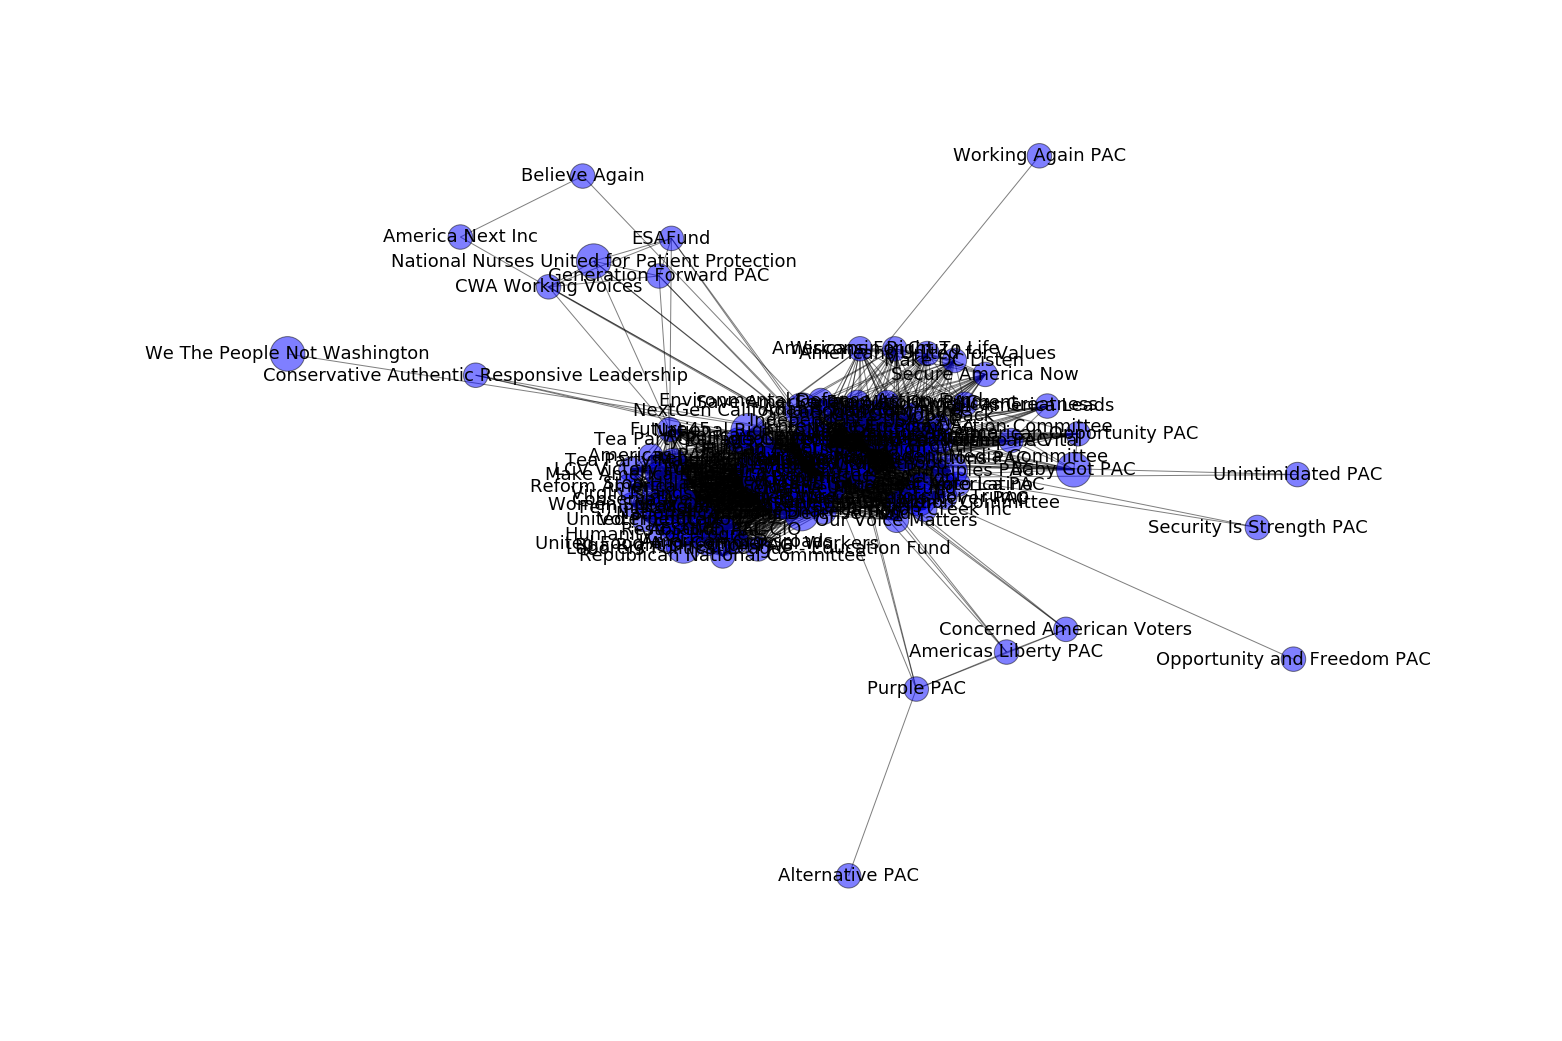

In [209]:
net.draw(pacnet2, node_size=np.exp(weights)*600, font_size=18, node_color='b', alpha=0.5, with_labels=True)

### 6.2 Trim out PACs that don't matter and replot

The plot shows large SuperPacs that spent on the same candidates -- either for or against their election.


In [210]:
## we'll raise the water to .75
pacnet2_trim2 = trim_edges(pacnet2, weight = math.exp(0.75))

## recalculate the weights
weights=[math.log(edata['weight']) for f, t, edata in pacnet2_trim2.edges(data = True)]

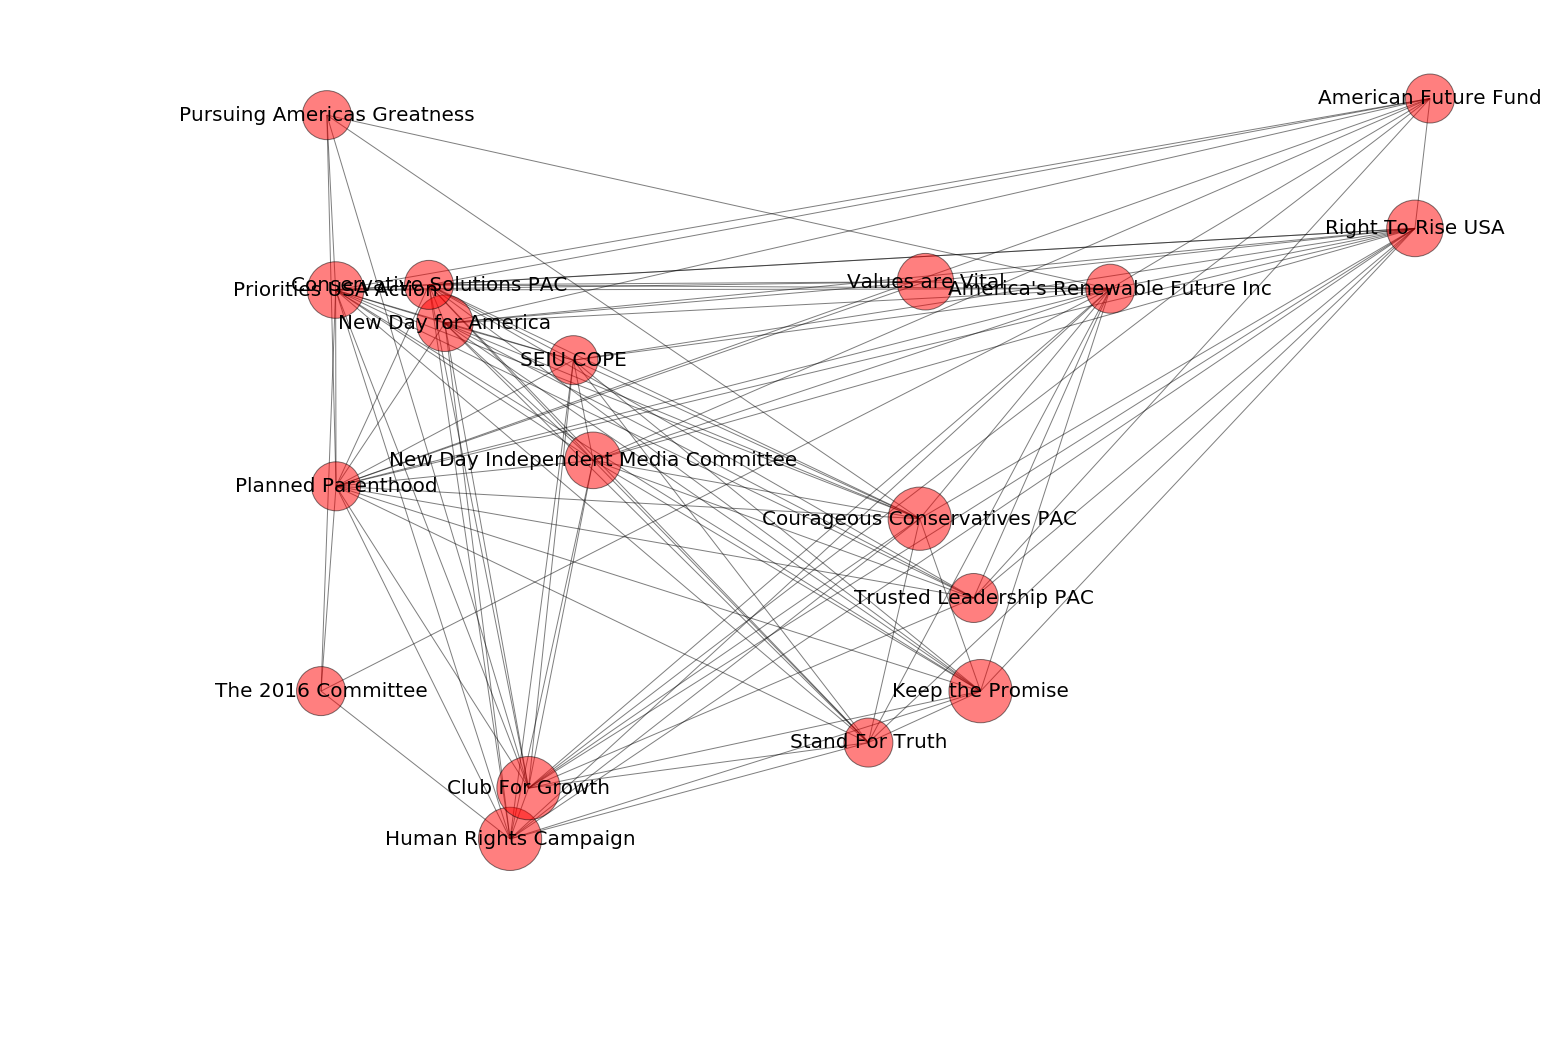

In [215]:
net.draw_random(pacnet2_trim2, node_size = np.exp(weights)*800, alpha=0.5, with_labels=True, font_size=20) 